# Continuous stirred tank reactor (CSTR)

In this Jupyter Notebook we illustrate the example **CSTR**.
We start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
%matplotlib notebook

## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the CSTR is continuous and has 4 states and 2 control inputs.
The model is initiated by:

In [3]:
# Initiate model and declare type

<span class="graffiti-highlight graffiti-id_e1ywjss-id_uxeqftb"><i></i><button>Show Solution</button></span>

Schematic diagram of CSTR system:

![CSTR_schematic](CSTR.pdf)

### States and control inputs

The four states are concentration of reactant A ($C_{\text{A}}$), the concentration of reactant B ($C_{\text{B}}$), the temperature inside the reactor ($T_{\text{R}}$) and the temperature of the cooling jacket ($T_{\text{K}}$):

In [ ]:
# Define states

<span class="graffiti-highlight graffiti-id_6bgfa0u-id_8f79cnv"><i></i><button>Hide Solution</button></span>

In [5]:
# States struct (optimization variables):
C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1))
C_b = model.set_variable(var_type='_x', var_name='C_b', shape=(1,1))
T_R = model.set_variable(var_type='_x', var_name='T_R', shape=(1,1))
T_K = model.set_variable(var_type='_x', var_name='T_K', shape=(1,1))

The control inputs are the feed $F$ and the heat flow $\dot{Q}$:

In [6]:
# Define inputs

<span class="graffiti-highlight graffiti-id_rjkvxf5-id_68evc2q"><i></i><button>Hide Solution</button></span>

In [7]:
# Input struct (optimization variables):
F = model.set_variable(var_type='_u', var_name='F')
Q_dot = model.set_variable(var_type='_u', var_name='Q_dot')

### ODE and parameters

The system model is described by the ordinary differential equation:

\begin{align}
\dot{C}_{\text{A}} &= F \cdot (C_{\text{A},0} - C_{\text{A}}) - k_1 \cdot C_{\text{A}} - k_3 \cdot C_{\text{A}}^2, \\
\dot{C}_{\text{B}} &= F \cdot C_{\text{B}} + k_1 \cdot C_{\text{A}} - k_2 \cdot C_{\text{B}}, \\
\dot{T}_{\text{R}} &= \frac{k_1 \cdot C_{\text{A}} \cdot H_{\text{R},ab} + k_2 \cdot C_{\text{B}} \cdot  H_{\text{R},bc} + k_3 \cdot C_{\text{A}}^2 \cdot H_{\text{R},ad}} {-\rho \cdot c_p}\\
&+ F \cdot (T_{\text{in}} - T_{\text{R}}) + \frac{K_w \cdot A_{\text{R}} \cdot(T_{\text{K}}-T_{\text{R}})}{\rho \cdot c_p \cdot V_{\text{R}}}, \\
\dot{T}_{\text{K}} &= \frac{\dot{Q} + k_w \cdot A_{\text{R}} \cdot T_{\text{dif}}}{m_k \cdot C_{p,k}},
\end{align}

where

\begin{align}
k_1 &= \beta \cdot k_{0,\text{ab}} \cdot \exp\left(\frac{-E_{\text{A},\text{ab}}}{T_{\text{R}}+273.15}\right), \\
k_1 &= k_{0,\text{bc}} \cdot \exp \left( \frac{-E_{\text{A},\text{bc}}}{T_{\text{R}}+273.15} \right), \\
k_3 &= k_{0,\text{ad}} \cdot \exp \left( \frac{-\alpha \cdot E_{\text{A},\text{ad}}}{T_{\text{R}}+273.15} \right).
\end{align}

The 
parameters $\alpha$ and $\beta$ are uncertain while the rest of the parameters is considered certain:

In [8]:
# Certain parameters
K0_ab = 1.287e12 # K0 [h^-1]
K0_bc = 1.287e12 # K0 [h^-1]
K0_ad = 9.043e9 # K0 [l/mol.h]
R_gas = 8.3144621e-3 # Universal gas constant
E_A_ab = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_bc = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_ad = 8560.0*1.0 #* R_gas# [kj/mol]
H_R_ab = 4.2 # [kj/mol A]
H_R_bc = -11.0 # [kj/mol B] Exothermic
H_R_ad = -41.85 # [kj/mol A] Exothermic
Rou = 0.9342 # Density [kg/l]
Cp = 3.01 # Specific Heat capacity [kj/Kg.K]
Cp_k = 2.0 # Coolant heat capacity [kj/kg.k]
A_R = 0.215 # Area of reactor wall [m^2]
V_R = 10.01 #0.01 # Volume of reactor [l]
m_k = 5.0 # Coolant mass[kg]
T_in = 130.0 # Temp of inflow [Celsius]
K_w = 4032.0 # [kj/h.m^2.K]
C_A0 = (5.7+4.5)/2.0*1.0 # Concentration of A in input Upper bound 5.7 lower bound 4.5 [mol/l]

In [ ]:
# Define uncertain parameters:

<span class="graffiti-highlight graffiti-id_6hjehiz-id_waxck4u"><i></i><button>Hide Solution</button></span>

In [9]:
# Uncertain parameters:
alpha = model.set_variable(var_type='_p', var_name='alpha')
beta = model.set_variable(var_type='_p', var_name='beta')

In [ ]:
# Define time-varying parameters:

<span class="graffiti-highlight graffiti-id_obqfvdl-id_uj247dh"><i></i><button>Hide Solution</button></span>

In [10]:
# Time-varying parameters:
T_in = model.set_variable(var_type='_tvp', var_name='T_in')
C_b_set = model.set_variable(var_type='_tvp', var_name='C_b_set')

Compute reaction rate from fixed and uncertain parameters:

In [11]:
# Auxiliary terms
K_1 = beta * K0_ab * exp((-E_A_ab)/((T_R+273.15)))
K_2 =  K0_bc * exp((-E_A_bc)/((T_R+273.15)))
K_3 = K0_ad * exp((-alpha*E_A_ad)/((T_R+273.15)))

Additionally, we define an artificial variable of interest, that is not a state of the system, but can be used later:

In [ ]:
# Define T_dif as auxiliary expression

<span class="graffiti-highlight graffiti-id_3m8jb9y-id_71komti"><i></i><button>Hide Solution</button></span>

In [12]:
T_dif = model.set_expression(expr_name='T_dif', expr=T_R-T_K)

Formulate the right-hand-side of the ordinary differential equations:

In [ ]:
# Set rhs

<span class="graffiti-highlight graffiti-id_rdlgtbx-id_djsdcf4"><i></i><button>Hide Solution</button></span>

In [13]:
model.set_rhs('C_a', F*(C_A0 - C_a) -K_1*C_a - K_3*(C_a**2))
model.set_rhs('C_b', -F*C_b + K_1*C_a - K_2*C_b)
model.set_rhs('T_R', ((K_1*C_a*H_R_ab + K_2*C_b*H_R_bc + K_3*(C_a**2)*H_R_ad)/(-Rou*Cp)) + F*(T_in-T_R) +(((K_w*A_R)*(-T_dif))/(Rou*Cp*V_R)))
model.set_rhs('T_K', (Q_dot + K_w*A_R*(T_dif))/(m_k*Cp_k))

Finally, the model setup is completed:

In [14]:
# Build the model
model.setup()

## Controller


Next, the model predictive controller is configured.
First, one member of the mpc class is generated with the prediction model defined above:

In [ ]:
# Initiate MPC controller

<span class="graffiti-highlight graffiti-id_ez19tf6-id_lqesdur"><i></i><button>Show Solution</button></span>

We choose the prediction horizon `n_horizon`. The time step `t_step` is set to approx. 20 seconds (in hours) and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [ ]:
# Configure MPC settings

<span class="graffiti-highlight graffiti-id_fw34qyt-id_lxc8c8b"><i></i><button>Show Solution</button></span>

Because the magnitude of the states and inputs is very different, we introduce scaling factors:

In [ ]:
# Scaling

<span class="graffiti-highlight graffiti-id_svtueh5-id_orshyao"><i></i><button>Show Solution</button></span>

### Objective

The goal of the CSTR is to obtain a mixture with a set concentration of $C_{\text{B,set}}$. The concrete value will change over time, which is why we use the previously defined time-varying parameters as a placeholder here.
Additionally, we add a penalty on input changes for both control inputs, to obtain a smooth control performance.

In [ ]:
# Define control objective

<span class="graffiti-highlight graffiti-id_5a0cnzm-id_33eph4v"><i></i><button>Show Solution</button></span>

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there are only upper and lower bounds for each state and the input:

In [ ]:
# Set bounds

<span class="graffiti-highlight graffiti-id_9te64tk-id_9811jlp"><i></i><button>Show Solution</button></span>

If a constraint is not critical, it is possible to implement it as a **soft** constraint.
This means, that a small violation of the constraint does not render the optimization infeasible.
Instead, a penalty term is added to the objective.
**Soft** constraints can always be applied, if small violations can be accepted and it might even be necessary to apply MPC in a safe way (by avoiding avoiding numerical instabilities).
In this case, we define the upper bounds of the reactor temperature as a **soft** constraint by using `mpc.set_nl_cons()`.

In [ ]:
# Set soft-constraint

<span class="graffiti-highlight graffiti-id_bsb16t1-id_5zlfzcv"><i></i><button>Show Solution</button></span>

### Time-varying parameters

The control objective is to track a certain concentration for the product $C_b$ for which we have introduced in the model the time-varying parameter ``C_b_set``. During runtime, we must choose concrete values for this parameter. 

The same holds for the inlet temperature ``T_in``, for which we assume a known profile`

Setting values to time-varying parameters is **a two-step process**: First, we obtain a structure that is based on our model definition and then we pass a function that is called at each controller iteration and which changes values in this structure.

In [ ]:
# Get tvp template:

<span class="graffiti-highlight graffiti-id_cjzl0zj-id_bsl6d66"><i></i><button>Show Solution</button></span>

To understand this structure better, it helps to query the ``labels``:

In [22]:
tvp_struct_mpc.labels()[:5]

['[_tvp,0,T_in,0]',
 '[_tvp,0,C_b_set,0]',
 '[_tvp,1,T_in,0]',
 '[_tvp,1,C_b_set,0]',
 '[_tvp,2,T_in,0]']

By default all values in this structure are initialized with zero:

In [23]:
tvp_struct_mpc['_tvp',0,'T_in']

DM(0)

Let's set some better default values:

In [24]:
tvp_struct_mpc['_tvp',:,'T_in'] = 130

We now want to set new values for all indices of the structure at each iteration. For this purpose we need to define a function that takes as input the current time and returns as output the structure:

```python
def tvp_fun_mpc(t_now):
    # Set values of tvp_struct_mpc
    
    return tvp_struct_mpc
```

In [ ]:
# Define tvp function

<span class="graffiti-highlight graffiti-id_rifrtlt-id_r4pihee"><i></i><button>Show Solution</button></span>

Finally, we need to pass the newly created function to the MPC instance:

In [ ]:
# Pass tvp function to mpc instance

<span class="graffiti-highlight graffiti-id_a7z37ja-id_1kb0gx2"><i></i><button>Show Solution</button></span>

### Uncertain values

The explicit values of the two uncertain parameters $\alpha$ and $\beta$, which are considered in the scenario tree, are given by:

In [ ]:
# Set uncertainty values

<span class="graffiti-highlight graffiti-id_s78cjyt-id_dhb3edz"><i></i><button>Show Solution</button></span>

The setup of the MPC controller is concluded by:

In [29]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [37]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [30]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [31]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.005
}

simulator.set_param(**params_simulator)

### Realizations of uncertain parameters

For the simulation, it is necessary to define the numerical realizations of the uncertain parameters in `p_struct_sim` and the time-varying parameters in `tvp_struct_sim`.
This works similar but not identical as for the MPC controller. 
The main difference is that the simulator is always evaluated with exact values of the uncertain parameters and only needs a single time-varying parameter (instead of a trajectory covering the prediction horizon).

First, we get the structure of the uncertain and time-varying parameters:

In [ ]:
# Get structures for parameters and time-varying parameters

<span class="graffiti-highlight graffiti-id_urd1eiu-id_ct98zw5"><i></i><button>Show Solution</button></span>

We define two functions which are called in each simulation step, which return the current realizations of the parameters, with respect to defined inputs (in this case `t_now`).

Note that the struct for the time-varying parameters contains the setpoint ``C_b_set``. This parameter has no influence on the simulator and thus we don't need to change the dafault value of zero.

In [ ]:
# Define tvp and p fun

<span class="graffiti-highlight graffiti-id_u0gooyc-id_qlt2034"><i></i><button>Show Solution</button></span>

These two custum functions are used in the simulation via:

In [34]:
simulator.set_tvp_fun(tvp_fun)
simulator.set_p_fun(p_fun)

By defining `p_fun` as above, the function will always return the value 1.0 for both $\alpha$ and $\beta$.
To finish the configuration of the simulator, call:

In [35]:
simulator.setup()

## Closed-loop simulation

For the simulation of the MPC configured for the CSTR, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration:

In [ ]:
# Set initial state (for all modules) and initial guess for MPC

<span class="graffiti-highlight graffiti-id_98jpupz-id_kthx0wh"><i></i><button>Show Solution</button></span>

Now, we simulate the closed-loop for 50 steps (and suppress the output of the cell with the magic command `%%capture`):

In [ ]:
# Run main-loop

<span class="graffiti-highlight graffiti-id_3vmfg0f-id_d0ixs74"><i></i><button>Show Solution</button></span>

## Animating the results

To animate the results, we first configure the **do-mpc** graphics object, which is initiated with the respective data object:

In [40]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

We quickly configure Matplotlib.

In [89]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 12

Create a simple plot to quickly check the results

In [ ]:
# Default plot

<span class="graffiti-highlight graffiti-id_zoakkyw-id_5277fbx"><i></i><button>Show Solution</button></span>

Or configure a more complex and custom plot:

In [ ]:
fig, ax = plt.subplots(5, sharex=True, figsize=(9,7))
# Add lines ...

<span class="graffiti-highlight graffiti-id_pl5pssi-id_lnb5aie"><i></i><button>Show Solution</button></span>

Use Ipython widgets to animate the plot

interactive(children=(IntSlider(value=0, description='t_ind', max=49), Output()), _dom_classes=('widget-intera…

<IPython.core.display.Javascript object>


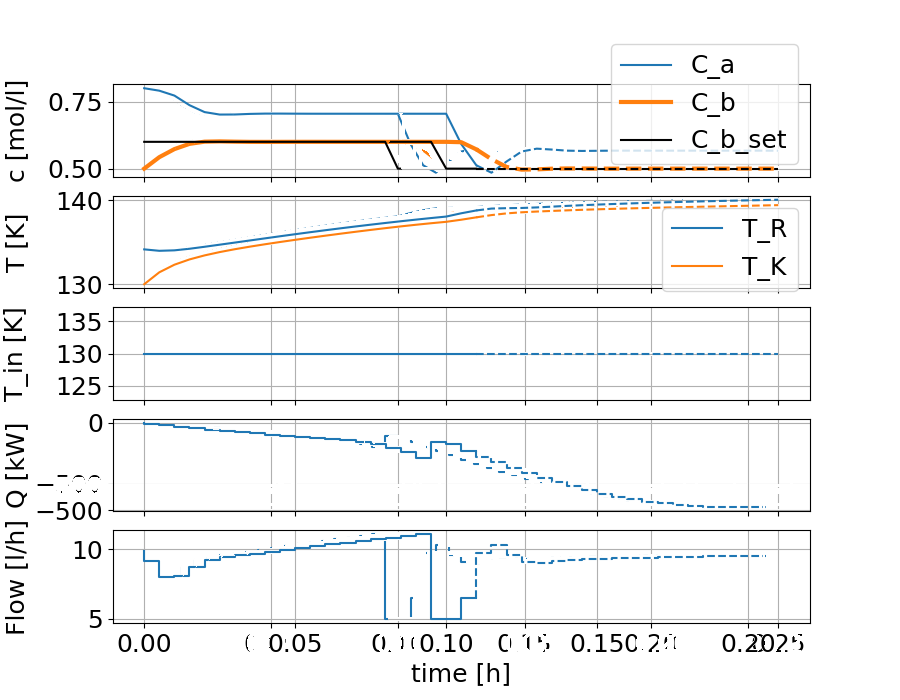

In [46]:
def plot_anim(t_ind=0):
    mpc_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()

    
widgets.interact(plot_anim,
        t_ind = widgets.IntSlider(value=0,min=0,max=N_sim-1)
        )

fig